In [762]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, classification_report, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import shap

In [763]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, pos_label=1)
    recall = recall_score(y_test, pred, pos_label=1)
    f1 = f1_score(y_test, pred, pos_label=1)

    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)

    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [764]:
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 110
pd.set_option('display.max_columns', None)

train_df = pd.read_csv("../../data/Bank_Churn_Dataset/train.csv")
test_df = pd.read_csv("../../data/Bank_Churn_Dataset/test.csv")
# df_test_ov = test_df.copy()
submission_df = pd.read_csv("../../data/Bank_Churn_Dataset/sample_submission.csv")

In [765]:
df_test_ov

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,275053,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,275054,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,275055,15687541,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


## Exploratory Data Analysis (EDA)

### 데이터 이해

In [766]:
train_df.shape

(165034, 14)

In [767]:
test_df.shape

(110023, 13)

In [768]:
submission_df.shape

(110023, 2)

In [769]:
submission_df.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


In [770]:
train_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [771]:
train_df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


> - Surname: 성(이름)
> - CreditScore: 신용 점수
> - Geography: 거주지 국가...?
> - Gender: 성
> - Age: 나이
> - Tenure: 은행을 이용한 기간
> - Balance: 계좌 잔액
> - NumOfProducts: 이용하는 은행 상품의 수(ex. 예금,적금)
> - HasCrCard: 신용카드 보유 여부
> - IsActiveMember: 활성 회원 여부
> - EstimatedSalary: 예상 연봉
> - Exited: 이탈 여부

### 결측치 및 이상치 처리

In [772]:
all_nan_columns = train_df.columns[train_df.isna().all()].tolist()
print(f"모든 값이 NaN인 컬럼 개수: {len(all_nan_columns)}")

train_df.drop(columns=all_nan_columns, inplace=True, axis=1)
test_df.drop(columns=all_nan_columns, inplace=True, axis=1)

모든 값이 NaN인 컬럼 개수: 0


In [773]:
unique_one_columns = [col for col in train_df.columns if train_df[col].nunique() == 1]
print(f'고유값이 1인 컬럼 개수: {len(unique_one_columns)}')

train_df.drop(columns=unique_one_columns, inplace=True, axis=1)
test_df.drop(columns=unique_one_columns, inplace=True, axis=1)

고유값이 1인 컬럼 개수: 0


In [774]:
target_cnt = train_df['Exited'].count()

print(train_df['Exited'].value_counts())
train_df['Exited'].value_counts() / target_cnt

Exited
0    130113
1     34921
Name: count, dtype: int64


Exited
0    0.788401
1    0.211599
Name: count, dtype: float64

In [775]:
test_df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [776]:
train_df.drop(['id', 'CustomerId'], axis=1, inplace=True)
test_df.drop(['id', 'CustomerId'], axis=1, inplace=True)

In [777]:
train_df.duplicated().sum()

54

In [778]:
duplicate_all = train_df[train_df.duplicated(keep=False)]
duplicate_all[duplicate_all['Surname']== 'Cunningham']

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6896,Cunningham,595,Spain,Male,35.0,8,0.0,1,0.0,1.0,100015.79,0
14256,Cunningham,595,Spain,Male,35.0,8,0.0,1,0.0,1.0,100015.79,0


In [779]:
train_df = train_df.drop_duplicates()
train_df

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [780]:
y = train_df['Exited']
X = train_df.drop(['Exited'], axis=1)

In [781]:
train_with_target = pd.concat([X, y], axis=1)

duplicates = train_with_target.duplicated(keep=False)
duplicates_with_different_target = duplicates & (train_with_target.groupby(list(X.columns))['Exited'].transform('nunique') > 1)

noise = train_with_target[duplicates_with_different_target]
cleaned_train = train_with_target[~duplicates_with_different_target]

X = cleaned_train.drop('Exited', axis=1)
y = cleaned_train['Exited']

In [782]:
noise

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


## feature Engineering

In [783]:
numeric_df = train_df.select_dtypes(include=['float', 'int']).columns
numeric_df = train_df[numeric_df]

In [784]:
corr = numeric_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.008975,0.000965,0.006948,0.011405,-0.002876,0.014844,-0.001891,-0.027442
Age,-0.008975,1.000000,-0.010839,0.064398,-0.102298,-0.012191,0.003261,-0.005420,0.340835
Tenure,0.000965,-0.010839,1.000000,-0.009513,0.007392,0.005343,-0.005499,0.000999,-0.019571
Balance,0.006948,0.064398,-0.009513,1.000000,-0.360986,-0.018614,-0.015014,0.008608,0.129715
NumOfProducts,0.011405,-0.102298,0.007392,-0.360986,1.000000,0.005471,0.039698,-0.004354,-0.214556
HasCrCard,-0.002876,-0.012191,0.005343,-0.018614,0.005471,1.000000,-0.020956,0.004508,-0.022169
IsActiveMember,0.014844,0.003261,-0.005499,-0.015014,0.039698,-0.020956,1.000000,-0.008105,-0.210230
EstimatedSalary,-0.001891,-0.005420,0.000999,0.008608,-0.004354,0.004508,-0.008105,1.000000,0.018782
Exited,-0.027442,0.340835,-0.019571,0.129715,-0.214556,-0.022169,-0.210230,0.018782,1.000000


In [785]:
age_exited_counts = numeric_df.groupby('Age')['Exited'].value_counts(normalize=True).unstack()
age_exited_counts

Exited,0,1
Age,,
18.0,0.864407,0.135593
19.0,0.915888,0.084112
20.0,0.934524,0.065476
21.0,0.951096,0.048904
22.0,0.872318,0.127682
...,...,...
82.0,0.857143,0.142857
83.0,0.666667,0.333333
84.0,1.000000,NaN


In [786]:
def get_age(age):
    cat = ''
    if age <= 23: cat = 'Student'
    elif age <= 39: cat = 'Young Adult'
    elif age <= 64: cat = 'Adult'
    else: cat = 'Elderly'        
    return cat

group_names = ['Student', 'Young Adult', 'Adult', 'Elderly']
 
train_df['Age_range'] = train_df['Age'].apply(lambda x : get_age(x))
test_df['Age_range'] = test_df['Age'].apply(lambda x : get_age(x))

In [787]:
age_range_counts = train_df.groupby('Age_range')['Exited'].value_counts(normalize=True).unstack()
age_range_counts

Exited,0,1
Age_range,,
Adult,0.592461,0.407539
Elderly,0.790650,0.209350
Student,0.908767,0.091233
Young Adult,0.896854,0.103146


In [788]:
Products_exited_counts = numeric_df.groupby('NumOfProducts')['Exited'].value_counts(normalize=True).unstack()
Products_exited_counts

Exited,0,1
NumOfProducts,,
1,0.652813,0.347187
2,0.939565,0.060435
3,0.117179,0.882821
4,0.124211,0.875789


In [789]:
train_df.groupby('Age_range')['NumOfProducts'].value_counts(normalize=True).unstack()

NumOfProducts,1,2,3,4
Age_range,,,,
Adult,0.568790,0.393378,0.032048,0.005785
Elderly,0.468496,0.506098,0.022358,0.003049
Student,0.405944,0.582764,0.010698,0.000594
Young Adult,0.413571,0.575816,0.009330,0.001282


In [790]:
tenure_exited_counts = numeric_df.groupby('Tenure')['Exited'].value_counts(normalize=True).unstack()
tenure_exited_counts

Exited,0,1
Tenure,,
0,0.745157,0.254843
1,0.773799,0.226201
2,0.805047,0.194953
3,0.770868,0.229132
4,0.773631,0.226369
5,0.779851,0.220149
6,0.801163,0.198837
7,0.812314,0.187686
8,0.802010,0.197990


In [791]:
train_df['Products_Per_Tenure'] =  train_df['Tenure'] / train_df['NumOfProducts']
test_df['Products_Per_Tenure'] =  test_df['Tenure'] / test_df['NumOfProducts']

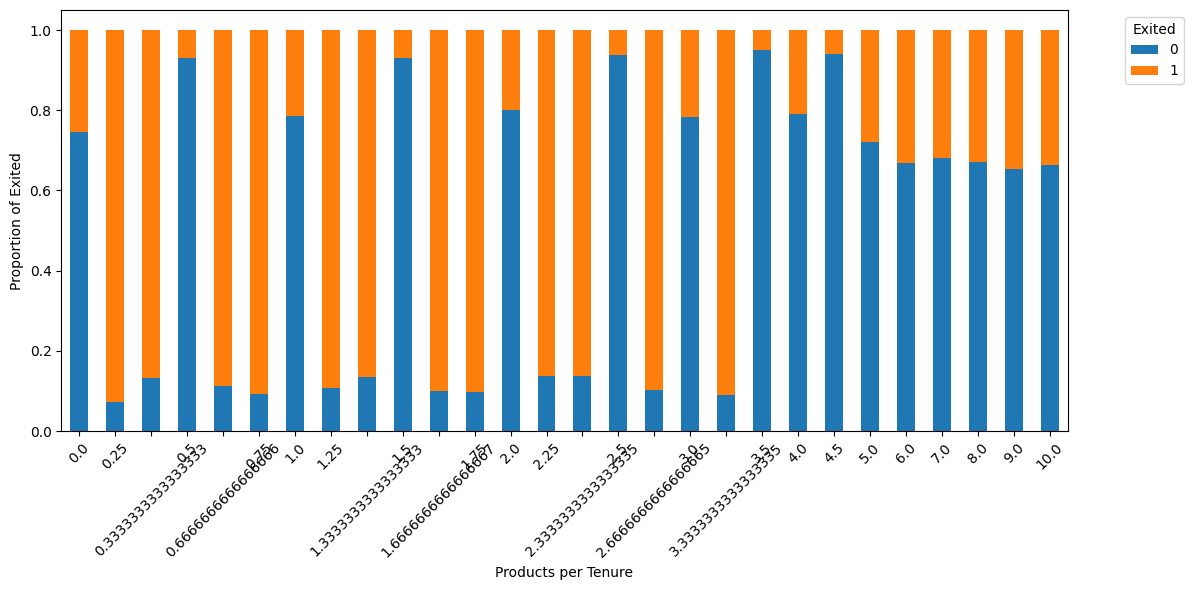

In [792]:
products_per_tenure_counts = train_df.groupby('Products_Per_Tenure')['Exited'].value_counts(normalize=True).unstack()

# Plotting
products_per_tenure_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('Products per Tenure')
plt.ylabel('Proportion of Exited')
plt.legend(title='Exited', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [793]:
credit_exited_counts = numeric_df.groupby('CreditScore')['Exited'].value_counts(normalize=True).unstack()
credit_exited_counts

Exited,0,1
CreditScore,,
350,0.736842,0.263158
358,NaN,1.000000
359,1.000000,NaN
363,1.000000,NaN
365,0.500000,0.500000
...,...,...
846,0.772727,0.227273
847,0.854167,0.145833
848,0.714286,0.285714


In [794]:
def get_fico(age):
    cat = ''
    if age <= 579: cat = 'Poor'
    elif age <= 669: cat = 'Not_Good'
    elif age <= 799: cat = 'Very_Good'
    else: cat = 'Excellent'        
    return cat

group_names = ['Poor', 'Not_Good', 'Very_Good', 'Excellent']
 
train_df['Fico_Score'] = train_df['CreditScore'].apply(lambda x : get_fico(x))
test_df['Fico_Score'] = test_df['CreditScore'].apply(lambda x : get_fico(x))

In [795]:
credit_exited_counts = train_df.groupby('Fico_Score')['Exited'].value_counts(normalize=True).unstack()
credit_exited_counts

Exited,0,1
Fico_Score,,
Excellent,0.796048,0.203952
Not_Good,0.780996,0.219004
Poor,0.764662,0.235338
Very_Good,0.803874,0.196126


In [796]:
train_df['Balance_to_EstimatedSalary'] = train_df['Balance'] / train_df['EstimatedSalary']
test_df['Balance_to_EstimatedSalary'] = test_df['Balance'] / test_df['EstimatedSalary']
train_df

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_range,Products_Per_Tenure,Fico_Score,Balance_to_EstimatedSalary
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,Young Adult,1.5,Not_Good,0.000000
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,Young Adult,0.5,Not_Good,0.000000
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,Adult,5.0,Very_Good,0.000000
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,Young Adult,2.0,Not_Good,1.760655
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,Young Adult,2.5,Very_Good,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,Young Adult,2.0,Not_Good,0.000000
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,Young Adult,3.0,Very_Good,0.000000
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,Young Adult,5.0,Poor,0.000000
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,Young Adult,7.0,Poor,2.269582


In [797]:
credit_exited_counts = train_df.groupby('Balance_to_EstimatedSalary')['Exited'].value_counts(normalize=True).unstack()
credit_exited_counts

Exited,0,1
Balance_to_EstimatedSalary,,
0.000000,0.838292,0.161708
0.000148,1.000000,NaN
0.021284,0.500000,0.500000
0.040204,1.000000,NaN
0.057708,NaN,1.000000
...,...,...
10874.005181,1.000000,NaN
11119.198618,1.000000,NaN
11699.463559,1.000000,NaN


In [798]:
nan_exited_1 = credit_exited_counts[credit_exited_counts[1].isna()]
nan_exited_1

Exited,0,1
Balance_to_EstimatedSalary,,
0.000148,1.0,NaN
0.040204,1.0,NaN
0.073273,1.0,NaN
0.074912,1.0,NaN
0.088076,1.0,NaN
...,...,...
10614.653713,1.0,NaN
10874.005181,1.0,NaN
11119.198618,1.0,NaN


In [799]:
category_df = train_df.select_dtypes(include=['object']).columns
category_df = train_df[category_df]
category_df

,Surname,Geography,Gender,Age_range,Fico_Score
0,Okwudilichukwu,France,Male,Young Adult,Not_Good
1,Okwudiliolisa,France,Male,Young Adult,Not_Good
2,Hsueh,France,Male,Adult,Very_Good
3,Kao,France,Male,Young Adult,Not_Good
4,Chiemenam,Spain,Male,Young Adult,Very_Good
...,...,...,...,...,...
165029,Meng,Spain,Female,Young Adult,Not_Good
165030,Okechukwu,France,Male,Young Adult,Very_Good
165031,Hsia,France,Male,Young Adult,Poor
165032,Hsiung,Spain,Female,Young Adult,Poor


In [800]:
sum_columns = ['Surname', 'Geography', 'Gender']
sum_columns

['Surname', 'Geography', 'Gender']

In [801]:
train_df['Surename_Geography_Gender'] = train_df[sum_columns].apply(lambda x: '_'.join(x.astype(str)), axis=1)
test_df['Surename_Geography_Gender'] = test_df[sum_columns].apply(lambda x: '_'.join(x.astype(str)), axis=1)

# drop

In [802]:
y = train_df['Exited']
# X = train_df.drop(['Exited'], axis=1)

X = train_df.drop(['Exited','Surname'], axis=1)
test_df = test_df.drop(['Surname'], axis=1)

In [803]:
X.drop(['Surename_Geography_Gender'], axis=1, inplace=True)
test_df.drop(['Surename_Geography_Gender'], axis=1, inplace=True)

In [804]:
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age_range,Products_Per_Tenure,Fico_Score,Balance_to_EstimatedSalary
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,Young Adult,1.5,Not_Good,0.000000
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,Young Adult,0.5,Not_Good,0.000000
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,Adult,5.0,Very_Good,0.000000
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,Young Adult,2.0,Not_Good,1.760655
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,Young Adult,2.5,Very_Good,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,Young Adult,2.0,Not_Good,0.000000
165030,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,Young Adult,3.0,Very_Good,0.000000
165031,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,Young Adult,5.0,Poor,0.000000
165032,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,Young Adult,7.0,Poor,2.269582


## Model

In [805]:
columns = X.columns
columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Age_range', 'Products_Per_Tenure', 'Fico_Score',
       'Balance_to_EstimatedSalary'],
      dtype='object')

In [806]:
numeric_X = X.select_dtypes(include=['float', 'int']).columns
numeric_X

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Products_Per_Tenure',
       'Balance_to_EstimatedSalary'],
      dtype='object')

In [807]:
category_X = X.select_dtypes(include=['object']).columns
category_X

Index(['Geography', 'Gender', 'Age_range', 'Fico_Score'], dtype='object')

In [808]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[numeric_X] = scaler.fit_transform(X[numeric_X])
test_df[numeric_X] = scaler.transform(test_df[numeric_X])

X = pd.DataFrame(X, columns=columns)
test_df = pd.DataFrame(test_df, columns=columns)

In [816]:
# label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for i in category_X:
    encoder = LabelEncoder()
    encoder.fit(X[i])
    
    X[i] = encoder.transform(X[i])
    test_df[i] = encoder.transform(test_df[i])

In [817]:
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age_range,Products_Per_Tenure,Fico_Score,Balance_to_EstimatedSalary
0,0.144025,0,1,-0.578123,-0.720006,-0.883233,0.814363,0.571256,-0.99550,1.369474,3,-0.859174,1,-0.022925
1,-0.367858,0,1,-0.578123,-1.432713,-0.883233,0.814363,0.571256,1.00452,-1.254161,3,-1.256387,1,-0.022925
2,0.268874,0,1,0.211406,1.774469,-0.883233,0.814363,0.571256,-0.99550,1.437412,0,0.531071,3,-0.022925
3,-0.942166,0,1,-0.465333,-1.076359,1.486778,-1.013254,0.571256,1.00452,-0.557077,3,-0.660567,1,-0.003716
4,0.743302,2,1,-0.578123,-0.007299,-0.883233,0.814363,0.571256,1.00452,-1.938863,3,-0.461961,3,-0.022925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,0.131540,2,0,-0.578123,-1.076359,-0.883233,-1.013254,0.571256,1.00452,0.382921,3,-0.660567,1,-0.022925
165030,1.692158,0,1,-0.352543,-0.720006,-0.883233,-1.013254,-1.750528,-0.99550,0.382915,3,-0.263355,3,-0.022925
165031,-1.141925,0,1,-0.803702,-0.007299,-0.883233,-1.013254,0.571256,1.00452,0.295328,3,0.531071,2,-0.022925
165032,-1.279259,2,0,-0.916492,0.705408,1.688156,-1.013254,-1.750528,1.00452,-0.823282,3,1.325496,2,0.001837


In [811]:
s

NameError: name 's' is not defined

## XGBoost

In [818]:
num_folds=5
n_est=3500

In [819]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE)

In [820]:
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, plot_importance

xgb_search_space = {'max_depth': hp.quniform('max_depth', 2, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100,
                            max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate'],
                            early_stopping_rounds=30,
                            eval_metric='auc',
                           random_state=RANDOM_STATE)
    
    roc_auc_list= []
    kf = KFold(n_splits=5)
    
    for tr_index, val_index in kf.split(X_train):
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
    return -1 * np.mean(roc_auc_list)

trials = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials,
            rstate=np.random.default_rng()
           )
print('best:', best)

xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']), eval_metric="logloss",
                        colsample_bytree=round(best['colsample_bytree'], 5), random_state=RANDOM_STATE, verbose=False)

xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

100%|████████| 50/50 [04:15<00:00,  5.10s/trial, best loss: -0.8890549414727815]
best: {'colsample_bytree': 0.7393121963846839, 'learning_rate': 0.17606426538821043, 'max_depth': 4.0, 'min_child_weight': 3.0}
[0]	validation_0-logloss:0.48934	validation_1-logloss:0.48473
[1]	validation_0-logloss:0.45285	validation_1-logloss:0.44797
[2]	validation_0-logloss:0.43233	validation_1-logloss:0.42788
[3]	validation_0-logloss:0.40921	validation_1-logloss:0.40485
[4]	validation_0-logloss:0.39255	validation_1-logloss:0.38834
[5]	validation_0-logloss:0.38073	validation_1-logloss:0.37664
[6]	validation_0-logloss:0.37073	validation_1-logloss:0.36676
[7]	validation_0-logloss:0.36238	validation_1-logloss:0.35833
[8]	validation_0-logloss:0.35654	validation_1-logloss:0.35244
[9]	validation_0-logloss:0.35272	validation_1-logloss:0.34890
[10]	validation_0-logloss:0.34577	validation_1-logloss:0.34153
[11]	validation_0-logloss:0.34234	validation_1-logloss:0.33799
[12]	validation_0-logloss:0.33879	validation_

In [821]:
pred = xgb_clf.predict(X_train) 
proba = xgb_clf.predict_proba(X_train)[:, 1]

best_rf_pred = xgb_clf.predict(X_test) 
best_rf_proba = xgb_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_train, pred, proba)
get_clf_eval(y_test , best_rf_pred, best_rf_proba)

오차 행렬
[[87008  4035]
 [10024 14419]]
정확도: 0.8783, 정밀도: 0.7813, 재현율: 0.5899,    F1: 0.6723, AUC:0.9098
오차 행렬
[[36930  2088]
 [ 4701  5775]]
정확도: 0.8628, 정밀도: 0.7345, 재현율: 0.5513,    F1: 0.6298, AUC:0.8872


In [822]:
# 최적 파라미터로 모델 학습 및 교차 검증
test_preds = np.empty((num_folds, len(test_df)))
auc_vals = []

folds = StratifiedKFold(n_splits=num_folds, random_state=RANDOM_STATE, shuffle=True)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    
    y_pred_val = xgb_clf.predict_proba(X_val)[:, 1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print(f"AUC for fold {n_fold}: {auc_val}")
    auc_vals.append(auc_val)
    
    y_pred_test = xgb_clf.predict_proba(test_df)[:, 1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

y_pred = test_preds.mean(axis=0)

print(f"최종 예측값 (y_pred): {y_pred}")

[0]	validation_0-logloss:0.48863
[1]	validation_0-logloss:0.45057
[2]	validation_0-logloss:0.42995
[3]	validation_0-logloss:0.40626
[4]	validation_0-logloss:0.38943
[5]	validation_0-logloss:0.37596
[6]	validation_0-logloss:0.36576
[7]	validation_0-logloss:0.35787
[8]	validation_0-logloss:0.35195
[9]	validation_0-logloss:0.34825
[10]	validation_0-logloss:0.34171
[11]	validation_0-logloss:0.33822
[12]	validation_0-logloss:0.33499
[13]	validation_0-logloss:0.33312
[14]	validation_0-logloss:0.32984
[15]	validation_0-logloss:0.32754
[16]	validation_0-logloss:0.32628
[17]	validation_0-logloss:0.32530
[18]	validation_0-logloss:0.32451
[19]	validation_0-logloss:0.32364
[20]	validation_0-logloss:0.32299
[21]	validation_0-logloss:0.32244
[22]	validation_0-logloss:0.32188
[23]	validation_0-logloss:0.32143
[24]	validation_0-logloss:0.32099
[25]	validation_0-logloss:0.32068
[26]	validation_0-logloss:0.32035
[27]	validation_0-logloss:0.32010
[28]	validation_0-logloss:0.31982
[29]	validation_0-loglos

In [ ]:
# df_sub = pd.read_csv("../../data/Bank_Churn_Dataset/sample_submission.csv")

In [823]:
submission_df['Exited'] = y_pred

In [824]:
submission_df.head()

,id,Exited
0,165034,0.043106
1,165035,0.816210
2,165036,0.022420
3,165037,0.275221
4,165038,0.379002


In [825]:
submission_df.to_csv("submission.csv",index=False)

## LightGBM

In [ ]:
num_folds=5
n_est=3500

In [ ]:
import optuna

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }

    lgb_model = LGBMClassifier(**param, random_state=RANDOM_STATE, verbose=-1)
    lgb_model.fit(X_train, y_train, feature_name=['f' + str(i) for i in range(X_train.shape[1])])
    y_val_pred = lgb_model.predict(X_test)
    f1 = f1_score(y_test, y_val_pred, pos_label=1) 
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

best_params = study.best_params
print("Best params: ", best_params)

best_lgb_model = LGBMClassifier(**best_params, random_state=RANDOM_STATE)
best_lgb_model.fit(X_train, y_train, feature_name=['f' + str(i) for i in range(X_train.shape[1])])

In [ ]:
pred = best_lgb_model.predict(X_train) 
proba = best_lgb_model.predict_proba(X_train)[:, 1]

best_rf_pred = best_lgb_model.predict(X_test) 
best_rf_proba = best_lgb_model.predict_proba(X_test)[:, 1]

get_clf_eval(y_train, pred, proba)
get_clf_eval(y_test , best_rf_pred, best_rf_proba)

In [ ]:
# 최적 파라미터로 모델 학습 및 교차 검증
test_preds = np.empty((num_folds, len(test_df)))
auc_vals = []

folds = StratifiedKFold(n_splits=num_folds, random_state=RANDOM_STATE, shuffle=True)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    # 최적화된 파라미터로 LightGBM 모델 학습
    best_lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    
    # 검증 데이터에 대한 예측
    y_pred_val = best_lgb_model.predict_proba(X_val)[:, 1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print(f"AUC for fold {n_fold}: {auc_val}")
    auc_vals.append(auc_val)
    
    # 테스트 데이터에 대한 예측을 저장
    y_pred_test = best_lgb_model.predict_proba(test_df)[:, 1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

# 모든 fold에서의 테스트 예측값 평균 계산
y_pred = test_preds.mean(axis=0)

print(f"최종 예측값 (y_pred): {y_pred}")

In [ ]:
df_sub = pd.read_csv("../../data/Bank_Churn_Dataset/sample_submission.csv")

In [ ]:
# y_pred_binary = (y_pred >= 0.5).astype(int)

In [ ]:
# df_sub['Exited'] = y_pred_binary
df_sub['Exited'] = y_pred

In [ ]:
df_sub.head()

In [ ]:
df_sub.to_csv("submission.csv",index=False)

## CatBoost - data leakage

In [ ]:
USE_DATA_LEAK='N' ## Set to Y to exploit data leak

num_folds=5 ## Number of folds
n_est=3500 ## Number of estimators

In [ ]:
feat_cols = X.columns

In [ ]:
X

In [ ]:
cat_features = np.where(X.dtypes != np.float64)[0]
cat_features

> - Pool은 데이터와 라벨, 범주형 피처 정보를 포함하는 구조
> - cat_features: 이 변수는 범주형 피처의 인덱스를 나타냅니다. CatBoost는 범주형 데이터를 직접 처리할 수 있기 때문에 이를 명시

In [ ]:
folds = StratifiedKFold(n_splits=num_folds, random_state=RANDOM_STATE, shuffle=True)
test_preds = np.empty((num_folds, len(test_df)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)
    
    clf = CatBoostClassifier(eval_metric='AUC', learning_rate=0.03, iterations=n_est)
    clf.fit(train_pool, eval_set=val_pool, verbose=300)
    
    y_pred_val = clf.predict_proba(X_val)[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ", n_fold, ": ", auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = clf.predict_proba(test_df)[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
y_pred = test_preds.mean(axis=0)
y_pred

In [ ]:
ori_df = pd.read_csv("../../data/Bank_Churn_Dataset/Churn_Modelling.csv")
ori_df

In [ ]:
target_cnt = ori_df['Exited'].count()

print(ori_df['Exited'].value_counts())
ori_df['Exited'].value_counts() / target_cnt

In [ ]:
join_cols = list(ori_df.columns.drop(['RowNumber', 'Exited']))
join_cols

In [ ]:
ori_df.rename(columns={'Exited': 'Exited_Orig'}, inplace=True)
ori_df['Exited_Orig'] = ori_df['Exited_Orig'].map({0: 1, 1: 0})

In [ ]:
ori_df

In [ ]:
target_cnt = ori_df['Exited_Orig'].count()

print(ori_df['Exited_Orig'].value_counts())
ori_df['Exited_Orig'].value_counts() / target_cnt

In [ ]:
df_test_ov

In [ ]:
df_test_ov = df_test_ov.merge(ori_df, on=join_cols, how='left')[['id', 'Exited_Orig']].fillna(-1)
df_test_ov

In [ ]:
df_sub = df_test_ov[['id', 'Exited_Orig']]

In [ ]:
if USE_DATA_LEAK == 'Y':
    df_sub['Exited'] = np.where(df_sub.Exited_Orig == -1, y_pred, df_sub.Exited_Orig)
else:
    df_sub['Exited'] = y_pred

In [ ]:
df_sub.drop('Exited_Orig', axis=1, inplace=True)

In [ ]:
df_sub = pd.read_csv("../../data/Bank_Churn_Dataset/sample_submission.csv")

In [ ]:
df_sub['Exited'] = y_pred

In [ ]:
df_sub.head()

In [ ]:
df_sub.to_csv("submission.csv",index=False)